In [1]:
# Tensorflow implementation of face generation using DCGAN
# roughly following this pyTorch tutorial
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
# the dataset I'm using is the UTKFACE (Zhang et al., 2017)
# available at
# https://susanqq.github.io/UTKFace/

# download dataset
import gdown
import tarfile
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = 'UTK.tar.gz'
gdown.download(url, output, quiet=False)

file = tarfile.open('UTK.tar.gz')
file.extractall('./UTKFace')
file.close()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)

Found 23708 files belonging to 1 classes.


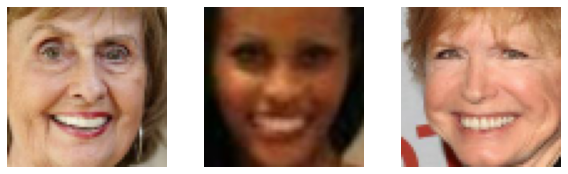

In [4]:
# load dataset
batch_size = 256

ds = tf.keras.utils.image_dataset_from_directory(
    directory='UTKFace', 
    labels=None, 
    batch_size=batch_size,
    image_size=(64, 64),
    shuffle=True
)
ds = ds.shuffle(10000, reshuffle_each_iteration=True)

plt.figure(figsize=(10, 10))
for images in ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

2022-12-31 16:25:03.636169: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-31 16:25:04.795044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-12-31 16:25:06.561227: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-31 16:25:06.567235: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-12-31 16:25:06.567288: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-12-31 16:25:06.567456: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED:

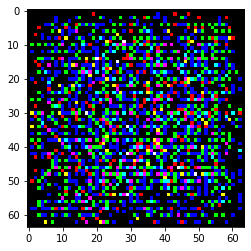

In [6]:
# initialize network

n_channel = 3 # color channels
n_vector = 100 # Size of z latent vector
n_output = 64 # Size of image
init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

gene = tf.keras.Sequential([
    layers.Conv2DTranspose(input_shape=(1,1,n_vector), filters=n_output*8, kernel_size=4, strides=1, padding='valid', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(filters=n_output*4, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(filters=n_output*2, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(filters=n_output, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2DTranspose(filters=n_channel, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.Activation("tanh")
])

disc = tf.keras.Sequential([
    layers.Conv2D(input_shape=[64,64,3], filters=n_output, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(filters=n_output * 2, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(filters=n_output * 4, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),

    layers.Conv2D(filters=n_output * 8, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=init),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
 
    layers.Conv2D(filters=1, kernel_size=4, strides=1, use_bias=False, kernel_initializer=init, activation='sigmoid')
])

yhat = gene(tf.random.normal([batch_size, 1, 1, n_vector]))
assert yhat[0].shape == (n_output,n_output,3)
assert disc(yhat).shape == (batch_size,1,1,1)
plt.imshow((yhat[0].numpy()*255).astype("uint8"))

In [7]:
# training loop helpers

# for generate labels (1 for real, 0 for fake)
def real_labels(size):
    return tf.ones((size, 1, 1, 1))
def fake_labels(size):
    return tf.zeros((size, 1, 1, 1))


optimizer_D = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
optimizer_G = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
loss_fn  = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def train_model(model, X, y):
    with tf.GradientTape() as tape:
        yhat = model(X, training=True)
        loss = loss_fn(y, yhat)
    grads = tape.gradient(loss, model.trainable_weights)
    return yhat.numpy(), loss.numpy().mean(), grads


# record training progress
n_sample = 16
fixed_noise = tf.random.normal([n_sample, 1, 1, n_vector])
gene_sample = []


# imshow for generatory output
def imshow2(img):
    """Transforms img from [-1,1] range to [0,255]"""
    return plt.imshow(((img+1)*127.5).numpy().astype("uint8"))

In [ ]:
epochs = 5000

for i in range(epochs):
    print(i, end=' ')
    
    # performance monitors
    loss_D = []  # loss for discriminator
    loss_G = []  # loss for generator
    D_x = []     # discriminator accuracy for real img
    D_g = []     # discriminator accuracy for fake img

    for all_real in ds:
        # generate batches
        size = len(all_real)
        noise = tf.random.normal([size, 1, 1, n_vector])
        all_fake = gene(noise)
        all_real = all_real / 127.5 - 1. # scale rgb to [-1,1] to match generator output

        # compute gradients for discriminator from real img batch
        yhat, loss, grads_real = train_model(disc, all_real, real_labels(size))
        D_x.append((yhat>0.5).mean())
        loss_D.append(loss)

        # compute gradients for discriminator from fake img batch
        yhat, loss, grads_fake = train_model(disc, all_fake, fake_labels(size))
        D_g.append((yhat>0.5).mean())
        loss_D.append(loss)

        # update discriminator with both gradients
        optimizer_D.apply_gradients([(g/2, v) for g, v in zip(grads_real, disc.trainable_weights)])
        optimizer_D.apply_gradients([(g/2, v) for g, v in zip(grads_fake, disc.trainable_weights)])
        
        # compute gradients for generator & update
        with tf.GradientTape() as tape:
            yhat = disc(gene(noise, training=True), training=True)
            loss_gene = loss_fn(real_labels(size), yhat)
        loss_G.append(loss_gene.numpy().mean())
        grads_gene = tape.gradient(loss_gene, gene.trainable_weights)
        optimizer_G.apply_gradients(zip(grads_gene, gene.trainable_weights))
    
    # performance per epoch
    print(
        np.format_float_scientific(np.array(loss_D).mean()), 
        np.format_float_scientific(np.array(loss_G).mean()),
        np.array(D_x).mean(),
        np.array(D_g).mean()
    )

    if i % 100 == 0:
        gene_sample.append(gene(fixed_noise))

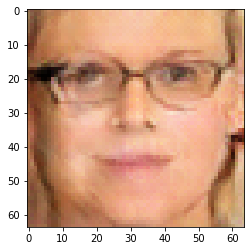

In [18]:
# random generation
imshow2(gene(tf.random.normal([1, 1, 1, n_vector]))[0])

In [ ]:
# display saved examples
for i in range(len(gene_sample)):
    plt.figure(figsize=(10, 10))
    for img, j in zip(gene_sample[i], range(1,17)):
            ax = plt.subplot(4, 4, j)
            imshow2(img)
            plt.axis("off")